# TOMOseq data analysis pipeline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, variation
from sklearn.preprocessing import normalize, scale, MinMaxScaler
import multiprocessing
%matplotlib inline
import seaborn

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Describe funciton to process de data

In [2]:
def accessData(list_files, list_labels):
    """opens the read/transcript/gene counts of each file"""
    #create empty dictionary to store the dataframes
    dic_dataframes = {}
    #iterate to get the file names
    #make a counter to access the correct label
    count = 0
    for file in list_files:
        #open each file
        data_frame = pd.read_csv(file, sep='\t', compression='gzip', index_col=0)
        #add the dataframe as an element of a dictionary with key the filename
        dic_dataframes[list_labels[count]] = data_frame
        count = count + 1
    
    return dic_dataframes


def plotTotalTranscriptCounts(data_genes,  thr=[4,4,4,4]):
    """plots de total transcript counts per section and the frecuencies. With the variable end we can define a 
    threshold to reduce the number of columns ploted. with thr we set the line for filtering threshold"""
    #create new dictionary to store the total counts
    data_total_log10 = {}
    data_total = {}
    count_threshold = 0

    #subsrtact the keys from the input dictionary
    for key in data_genes:
        name=key.split('_')
        name=' '.join(name)
        #sum all the values in the same column
        data_frame_total = data_genes[key].sum(axis="index")
        #transform to log10, for that we need to add +1 before because log10 of 0 is Na
        modified = data_frame_total+1
        data_frame_total_log10 = pd.DataFrame(np.log10(list(modified)), index=data_frame_total.index.values, columns=['log10'])

        data_frame_total_log10_plot=data_frame_total_log10
        #plot bar plot from the log10 total transcript counts
        data_frame_total_log10_plot.plot(kind='bar', legend=False, figsize=(3, 1.5), color='grey', width=0.75);
        plt.axhline(y=thr[count_threshold], color='r', linestyle='-.', linewidth = 1)
        plt.xlabel('Sections A-P (knee to ankle)', fontsize=7, fontname="Microsoft Sans Serif")
        plt.ylabel(name+' transcript counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
        plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
        plt.ylim([0, 7])
        #select everyother 10 labels from the list of column names
        plt.xticks(ticks=np.arange(0, 96, 10), labels=[str(i) for i in range(0,96,10)], rotation='horizontal', fontsize=7, fontname="Microsoft Sans Serif")
        plt.grid(which='major', axis='y', linestyle='--', c='k')
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig('Trans-counts_'+key+'.svg', format = 'svg', dpi=300, bbox_inches='tight')   
        plt.show()
        plt.close()
        
        #plot the frequency form the selection
        data_frame_total_log10_plot.plot(kind='hist', legend=False, figsize=(1, 1.5), bins=30, color='grey', orientation='horizontal');
        plt.axhline(y=thr[count_threshold], color='red', linestyle='-.', linewidth = 1)
        plt.ylim([0, 7])
        plt.xlabel('Frequency', fontsize=7, fontname="Microsoft Sans Serif")
        plt.title(name, fontsize=7, fontname="Microsoft Sans Serif")
        plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
        plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
        plt.grid(which='major', axis='y', linestyle='--', c='k')
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig('Trans-counts_freq_'+key+'.svg', format = 'svg', dpi=300, bbox_inches='tight')   
        plt.show()
        plt.close()
        
        #add 1 to the threshold count
        count_threshold = count_threshold + 1
        
        #save the data in new dictionary of total counts
        data_total_log10[key] = data_frame_total_log10
        data_total[key] = data_frame_total
    
    return data_total_log10, data_total




def thresholdEmptySlices1(dic_data_total_log10, dic_data, list_thresholds):
    """Filter empty slices form the dataset according to a threshold and rename columns"""
    #create an emtpy dictornary to store the filtered data and a counter 
    data_genes_filtered_s1 = {}
    #ceate an empty dic to store old column ids
    dic_filtering = {}
    #create a counter for the samples to subsrtact list_thresholds
    count_threshold = 0
    #get each dataset
    for key in dic_data_total_log10:
        data_frame_total_log10 = dic_data_total_log10[key]
        data_frame_genes = dic_data[key]
        #make a new dataframe to store the info
        filtered_s1 = pd.DataFrame()
        #make a count to rename the columns (number of columns)
        count_columns = 0
        old_column_label = []
        filter=pd.DataFrame(columns=['Filter'])
        #access each row of the log10 total transcripts counts
        for column_id in data_frame_total_log10.index.values:
            #check if the value of the column is bigger to the threshold
            if float(data_frame_total_log10.loc[column_id]) >= list_thresholds[count_threshold]: #float to transform series in float
                #add 1 to the count columns
                count_columns = count_columns + 1
                new_column_id = str('{0:03}'.format(count_columns)) #rename the columns by reshapeing the number (1) to 3 or more digits (001)
                #save the values from columns of the unfiltered data into filtered dataframe with new columns ids
                filtered_s1[new_column_id]= data_frame_genes[column_id]
                #save the new column id in the filtering info
                filter.loc[column_id]=new_column_id
            else:
                filter.loc[column_id]='No'
        #add 1 to the threshold count
        count_threshold = count_threshold + 1
        #save the filtered dataframe to the dictionary
        data_genes_filtered_s1[key] = filtered_s1
        #save the columns olds ids in dictionary
        dic_filtering[key] = filter
    
    return data_genes_filtered_s1, dic_filtering


def tomoseqFilter(row, thr, n):
    condition = False
    #first check that there is more than 4 sections reaching the thresholod for each gene
    if sum(row>thr)>4:
        i=0
        #in at lest 3 conecutive sections
        while i<n-2:
            if sum(row[i:i+3]>thr) >= 3:
                condition = True
                i = n
            else:
                i= i + 1    
    return condition



def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('_')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]


def filterMtRiboTOMOseq2(dic_data, remove_mt = False, remove_ribo = False, TOMOseq = False, threshold=10):
    """Filter out mithocondrial and ribosomal genes from the datasets"""
    """tomoseq paper: For correlation analysis, all genes expressed at >10 reads in >1 section were 
    selected prior to total-read-normalization."""
    #create new dictionary to store filtered data
    dic_genes_filtered = {}
    #access each dataframe individually
    for key in dic_data:
        dataframe = dic_data[key]
        #create a list with the gene information
        gene_info = list(dataframe.index.values)
        #we will make a table with the gene label split in the different parts, 
        #the index is the same as id and the columns have a part of the name
        dataframe_gene_info = pd.DataFrame(columns=['ID', 'name', 'type'], index=gene_info)
        #access each row element of the gene info list to split it 
        
        genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps', 'Rik_']
        exclude_genes_index = []
        for index in gene_info: 
            if any(exclude in index for exclude in genes):
                exclude_genes_index.append(index) 
        #we can filter out the genes using their index names we foudn previusly
        dataframe_filtered_s2 = dataframe.drop(exclude_genes_index)
         
        
        for element in gene_info:
            info_gene = element.split('_')
            #assign values to rows by the row name (index) with loc, 
            #each value of the list to save will be saved in a column
            dataframe_gene_info.loc[element] = [info_gene[0], info_gene[1], info_gene[-1]]
        if remove_mt == True:
            #select from the gene_info df the rows with chr MT
            positions = []
            for gene_name in dataframe_gene_info['name']:
                positions.append('mt.' in gene_name)
            #use the true false positions to selet the rows
            dataframe_gene_info_mt=dataframe_gene_info.loc[positions]
            #get the row index values from them and tansform to list
            mt_index = list(dataframe_gene_info_mt.index.values)
            #we can filter out the MT genes using their index names
            dataframe_filtered_s3 = dataframe_filtered_s2.drop(mt_index)
            print('MT genes removed')
        if remove_mt == False:
            dataframe_filtered_s3 = dataframe_filtered_s2
            print('MT genes NOT removed')
        
        if remove_ribo == True:
        #select from the gene_info df the rows with ribosomal genes and store their index 
            ribosomal_genes_index = []
            for index in dataframe_gene_info.index.values:
                if 'rRNA' in dataframe_gene_info.loc[index][2]:#'Rp'
                    ribosomal_genes_index.append(index) 

            #we can filter out the ribosomal genes using their index names we foudn previusly
            dataframe_filtered_s4 = dataframe_filtered_s3.drop(ribosomal_genes_index)
            print('Ribo genes removed')
        if remove_ribo == False:
            dataframe_filtered_s4 = dataframe_filtered_s3
            print('Ribo genes NOT removed')
            
        if TOMOseq == False:
            dataframe_filtered_s5 = dataframe_filtered_s4
            print('No TOMOseq filtering')
        if TOMOseq == True:
            #make a new dataframe to save TOMOseq filtration
            dataframe_filtered_s5 = pd.DataFrame(columns=dataframe_filtered_s4.columns)
            #go through the dataframe rows to select the ones that have more than X transcripts in at least 3 consecutive sections
            n_sections = len(dataframe_filtered_s4.columns)

            new_data = dataframe_filtered_s4.apply(tomoseqFilter, axis=1, result_type='reduce', args=(threshold, n_sections))
            
            idx_list=[]
            for index in new_data.index:
                if new_data.loc[index]:
                    idx_list.append(index)
            
            dataframe_filtered_s5 = dataframe_filtered_s4.loc[idx_list]
            print('TOMOseq filtering')
            
        #remove Gm genes using Anna's formula
        dataframe_filtered_s6 = removeGmGenes(dataframe_filtered_s5)
        #save the filtered dataframe into the new dictionary
        dic_genes_filtered[key] = dataframe_filtered_s6
    
    return dic_genes_filtered


def saveCSV(dic_data, label):
    """Save dataframes inside dictionary to csv files"""
    for key in dic_data:
        dic_data[key].to_csv(key+'_'+label+'.tsv.gz', sep='\t', compression='gzip')
    
    return print('Files saved')


def findNumberColumns(dic_data):
    """Find the position of the median value of total transcripts across sections to use for normalilzation
    prints the number of columns and returns the total transcript counts per sections"""
    #make an empty list to store the info
    number_columns = list()
    #make a count
    count = 0
    #empty dictionary to store total trancript counts
    dic_total = {}
    for key in dic_data:
        data_frame_total = dic_data[key].sum(axis='index')
        total_values = list(data_frame_total)
        #sort the total transcript values
        total_values.sort()
        dic_total[key] = total_values
        #get the total transcript counts per section
        number_columns.append(len(list(dic_data[key].columns.values)))
        #print number of valules 
        print('Number of values '+key +': ', number_columns[count])
        count = count + 1
    
    return dic_total


def normalizeMedian(dic_data, list_median):
    """Normalize to median
    1. divide by the total reads in each column
    2. multiply by the median of total raeds across sections"""
    #make a counter for the smaple number to select the median position
    count = 0
    #make a dictionary to store the normalized datasets
    dic_normal = {}
    #Get each dataframe
    for key in dic_data:
        #get the total transcript counts per section
        data_frame_total = dic_data[key].sum(axis='index')
        #divide each section by the total of the section
        data_frame_normal_s1 = dic_data[key].divide(data_frame_total, axis='columns')
        #multiply by the meadian value 
        data_frame_normal = data_frame_normal_s1.multiply(list_median[count])
        count = count + 1
        #save the dataframe to the dictionary
        dic_normal[key] = data_frame_normal
    
    return dic_normal


def plotGene(dic_data, list_gene, xlabel = 'Sections A-P', ylabel = 'Counts', limit=[-3,5]):
    """Plot the specified gene data"""
    #get gene data and plot
    for key in dic_data:
        data_frame = dic_data[key]
        #find the column values for the gene of interest
        for gene in list_gene:
            if gene in list(data_frame.index):
                gene_data = data_frame.loc[gene]
                #plot the data
                gene_name = gene.split('_')[1]
                gene_data.plot(label = gene_name);
        plt.xlabel(xlabel,fontsize=15);
        plt.ylabel(ylabel,fontsize=15);
        plt.ylim(limit)
        plt.legend(fontsize=15, frameon=False);
        plt.title(key,fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.show();
    
    return plt

## 1 - Filtering empty slices
#### Base on total number of reads/genes

In [3]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
path = ''

file_names = [path + 'Muscle_1_genes.t.t.counts.tsv.gz', 
              path + 'Muscle_2_genes.t.t.counts.tsv.gz',
              path + 'Muscle_3_genes.t.t.counts.tsv.gz',
              path + 'Muscle_4_genes.t.t.counts.tsv.gz',
             ]
labels = ['Muscle_1', 'Muscle_2', 'Muscle_3', 'Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data = accessData(file_names, labels)


In [4]:
#keep only relevant biotypes
data_genes={}
for key in data:
    keep_idx=[]
    for index in data[key].index:
        if 'lincRNA' in index:
            keep_idx.append(index)
        elif 'Protein' in index:
            keep_idx.append(index)
        elif 'rRNA' in index:
            keep_idx.append(index)
    print(key, len(keep_idx))
    data_genes[key]=data[key].loc[keep_idx]

Muscle_1 33613
Muscle_2 30814
Muscle_3 30353
Muscle_4 26732


In [5]:
#remove double mapping genes
data_genes_f={}
for key in data_genes:
    c=0
    remove_idx=[]
    for index in data_genes[key].index:
        if '-' in index:
            c=c+1
            remove_idx.append(index)
    data_genes_f[key]=data_genes[key].drop(remove_idx, axis=0)
    print(c)


14600
12185
11509
8576


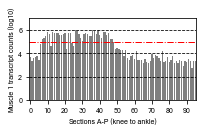

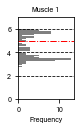

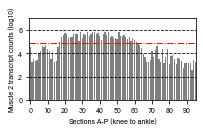

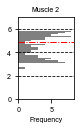

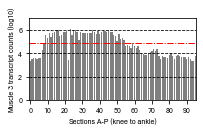

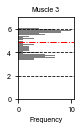

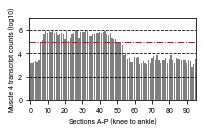

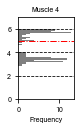

In [6]:
data_total_log10, data_total = plotTotalTranscriptCounts(data_genes_f, thr=[5,4.85,4.9,5])

In [7]:
##### set threshold to filter out empty slices and filter the datasets according the the log10 transcript 
#counts per slice
data_filtered_s1, data_filter = thresholdEmptySlices1(data_total_log10, data_genes_f, list_thresholds=[5, 4.85,4.9,5])
data_filtered_s1


{'Muscle_1':                                                     001         002  \
 new_gene                                                              
 ENSMUSG00000000001_Gnai3_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000028_Cdc45_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000031_H19_lincRNA               186.144646  239.860345   
 ENSMUSG00000000037_Scml2_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000049_Apoh_ProteinCoding          0.000000    0.000000   
 ...                                                 ...         ...   
 ENSMUSG00000118623_AL935121.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118638_AL805980.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118652_AL645799.1_lincRNA          0.000000    1.000000   
 ENSMUSG00000118653_AC159819.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118659_AC158307.1_lincRNA          0.000000    0.000000   
 
                                                  

In [8]:
data_filtering={}
data_filtering['Muscle_1']=pd.concat([data_total_log10['Muscle_1'],data_filter['Muscle_1']], axis=1)
data_filtering['Muscle_2']=pd.concat([data_total_log10['Muscle_2'],data_filter['Muscle_2']], axis=1)
data_filtering['Muscle_3']=pd.concat([data_total_log10['Muscle_3'],data_filter['Muscle_3']], axis=1)
data_filtering['Muscle_4']=pd.concat([data_total_log10['Muscle_4'],data_filter['Muscle_4']], axis=1)
data_filtering['Muscle_1']

,log10,Filter
289,3.665132,No
290,3.370732,No
291,3.578702,No
292,3.642296,No
293,3.759924,No
...,...,...
380,3.542955,No
381,3.301771,No
382,2.694052,No
383,3.344180,No


In [9]:
#saved
saveCSV(data_filtered_s1, label = 'genes.t.t.counts_filtered')

Files saved


## 5- Filter out ribosomal, bad genes and apply TOMOseq filtering
TOMOseq: For correlation analysis, all genes expressed at >4 reads in >1 section were selected prior to total-read-normalization.

In [10]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
path = ''

file_names = [path + 'Muscle_1_genes.t.t.counts_filtered.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered.tsv.gz',
              path + 'Muscle_3_genes.t.t.counts_filtered.tsv.gz', 
             path + 'Muscle_4_genes.t.t.counts_filtered.tsv.gz']
labels = ['Muscle_1', 'Muscle_2','Muscle_3', 'Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_filtered_s1 = accessData(file_names, labels)
data_filtered_s1['Muscle_1']

,001,002,003,004,005,006,007,008,009,010,...,028,029,030,031,032,033,034,035,036,037
new_gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001_Gnai3_ProteinCoding,0.000000,0.000000,1.000000,1.000000,0.000000,2.000244,0.000000,3.000733,0.000000,0.00000,...,4.001466,3.000733,0.000000,1.00000,2.000244,2.000244,2.000244,0.000000,0.000000,0.000000
ENSMUSG00000000028_Cdc45_ProteinCoding,0.000000,0.000000,0.000000,2.000244,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000000031_H19_lincRNA,186.144646,239.860345,478.882342,971.531232,844.238537,1514.246311,1404.302983,1143.685348,1022.550266,849.15658,...,636.994004,1788.029618,398.750438,245.16471,1003.343572,688.717424,414.209340,361.448546,266.451141,151.759125
ENSMUSG00000000037_Scml2_ProteinCoding,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000000049_Apoh_ProteinCoding,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,...,1.000000,1.000000,0.000000,0.00000,2.000244,1.000000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118623_AL935121.1_ProteinCoding,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118638_AL805980.1_ProteinCoding,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118652_AL645799.1_lincRNA,0.000000,1.000000,0.000000,2.000244,0.000000,2.000244,1.000000,1.000000,0.000000,0.00000,...,0.000000,2.000244,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
#Find mitocondrial and ribosomal genes which are expressed equally across sections. Therefore not interesting
data_genes_filtered = filterMtRiboTOMOseq2(data_filtered_s1, remove_mt = False, remove_ribo = True, TOMOseq = True, threshold=4)
data_genes_filtered

MT genes NOT removed
Ribo genes removed
TOMOseq filtering
MT genes NOT removed
Ribo genes removed
TOMOseq filtering
MT genes NOT removed
Ribo genes removed
TOMOseq filtering
MT genes NOT removed
Ribo genes removed
TOMOseq filtering


{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             186.144646  239.860345  478.882342   
 ENSMUSG00000000056_Narf_ProteinCoding        3.000733    1.000000    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        2.000244    1.000000    3.000733   
 ENSMUSG00000000085_Scmh1_ProteinCoding       1.000000    0.000000    1.000000   
 ENSMUSG00000000088_Cox5a_ProteinCoding      58.407432   61.451282  115.602376   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding       6.003666    8.006845    6.003666   
 ENSMUSG00000116564_Riok2_ProteinCoding       2.000244    2.000244    1.000000   
 ENSMUSG00000116590_AC154200.1_lincRNA       37.163590   28.092712   35.146102   
 ENSMUSG00000117924_Tmem223_ProteinCoding     2.000244    0.000000   10.011005   
 ENS

In [12]:
#save filtered files        
saveCSV(data_genes_filtered, label = 'genes.t.t.counts_filtered_noRibo_TOMOseq2-4')

Files saved


## 4- Normalization gene transcript counts to library size
### A) Normalize. Try whatever normalization you prefer: median, mean, ERCC, house-keeping… whatever you want. 

I will normalize to median.

TOMOseq paper: Read counts were normalized to total counts per section or by linear fits to spike-in RNA input/output plots (Figures S1A–S1D), depending on whether or not we wanted to retain differences in total reads per section caused by embryo geometry. The data were then renormalized to the median of total reads across sections in order to ensure that count numbers roughly corresponded to the number of mapped reads. For the 1D analyses described in Figures 2, 3, and 4 we used total read normalization in order to prevent biases caused by embryo geometry. For the 3D analyses shown in Figures 5, 6, and 7, on the other hand, we preferred spike-in normalization in order to be able to align microscopy data to sequencing data by crosscorrelation based on total read profiles (Figure 5E) (Junker et al., 2015).

In [13]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
path = ''

file_names = [path + 'Muscle_1_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz',
              path + 'Muscle_3_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz', 
             path + 'Muscle_4_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz']

labels = ['Muscle_1', 'Muscle_2','Muscle_3', 'Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_genes_filtered = accessData(file_names, labels)
data_genes_filtered['Muscle_1']

,001,002,003,004,005,006,007,008,009,010,...,028,029,030,031,032,033,034,035,036,037
new_gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000031_H19_lincRNA,186.144646,239.860345,478.882342,971.531232,844.238537,1514.246311,1404.302983,1143.685348,1022.550266,849.156580,...,636.994004,1788.029618,398.750438,245.164710,1003.343572,688.717424,414.209340,361.448546,266.451141,151.759125
ENSMUSG00000000056_Narf_ProteinCoding,3.000733,1.000000,0.000000,1.000000,4.001466,3.000733,6.003666,6.003666,2.000244,7.005133,...,4.001466,11.013452,3.000733,0.000000,17.033297,7.005133,4.001466,4.001466,3.000733,6.003666
ENSMUSG00000000078_Klf6_ProteinCoding,2.000244,1.000000,3.000733,9.008802,7.005133,15.025699,16.029375,7.005133,11.013452,8.006845,...,12.016145,29.099596,5.002443,4.001466,14.022268,10.011005,2.000244,8.006845,7.005133,1.000000
ENSMUSG00000000085_Scmh1_ProteinCoding,1.000000,0.000000,1.000000,4.001466,4.001466,10.011005,8.006845,6.003666,4.001466,8.006845,...,4.001466,12.016145,1.000000,1.000000,5.002443,7.005133,4.001466,2.000244,1.000000,0.000000
ENSMUSG00000000088_Cox5a_ProteinCoding,58.407432,61.451282,115.602376,209.229770,136.224272,263.251114,196.621756,230.329765,180.916125,187.191152,...,152.796880,462.058410,105.330236,60.436414,210.282192,211.334885,82.821811,132.091578,62.466401,47.265963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000115987_Vps28_ProteinCoding,6.003666,8.006845,6.003666,17.033297,12.016145,28.092712,23.062002,24.067650,17.033297,10.011005,...,24.067650,44.232634,9.008802,9.008802,39.182072,31.114106,17.033297,19.041879,10.011005,6.003666
ENSMUSG00000116564_Riok2_ProteinCoding,2.000244,2.000244,1.000000,1.000000,3.000733,4.001466,4.001466,3.000733,2.000244,3.000733,...,0.000000,7.005133,2.000244,0.000000,5.002443,4.001466,2.000244,2.000244,0.000000,2.000244
ENSMUSG00000116590_AC154200.1_lincRNA,37.163590,28.092712,35.146102,92.014856,47.265963,110.463086,105.330236,76.704558,73.649355,93.037581,...,82.821811,193.475808,48.277573,17.033297,140.361141,109.436001,47.265963,57.393318,26.079686,20.046540


In [14]:

genes=[]
for index in data_genes_filtered['Muscle_1'].index:
    if 'Myl' in index:
        genes.append(index)
genes

['ENSMUSG00000022836_Mylk_ProteinCoding',
 'ENSMUSG00000024048_Myl12a_ProteinCoding',
 'ENSMUSG00000027470_Mylk2_ProteinCoding',
 'ENSMUSG00000030672_Mylpf_ProteinCoding',
 'ENSMUSG00000039824_Myl6b_ProteinCoding',
 'ENSMUSG00000044951_Mylk4_ProteinCoding',
 'ENSMUSG00000059741_Myl3_ProteinCoding',
 'ENSMUSG00000061816_Myl1_ProteinCoding',
 'ENSMUSG00000067818_Myl9_ProteinCoding',
 'ENSMUSG00000090841_Myl6_ProteinCoding']

In [15]:
#filter out genes that plateau due to not enought UMIs
data_genes_filtered_2={}
for key in data_genes_filtered:
    print(key)
    for index in data_genes_filtered[key].index:
        if sum([i>60000 for i in data_genes_filtered[key].loc[index]])>=1:
            print(index)

Muscle_1
ENSMUSG00000030730_Atp2a1_ProteinCoding
ENSMUSG00000064341_mt.Nd1_ProteinCoding
ENSMUSG00000064345_mt.Nd2_ProteinCoding
ENSMUSG00000064354_mt.Co2_ProteinCoding
ENSMUSG00000064357_mt.Atp6_ProteinCoding
ENSMUSG00000064363_mt.Nd4_ProteinCoding
ENSMUSG00000064367_mt.Nd5_ProteinCoding
ENSMUSG00000064370_mt.Cytb_ProteinCoding
Muscle_2
ENSMUSG00000030730_Atp2a1_ProteinCoding
ENSMUSG00000064341_mt.Nd1_ProteinCoding
ENSMUSG00000064345_mt.Nd2_ProteinCoding
ENSMUSG00000064357_mt.Atp6_ProteinCoding
ENSMUSG00000064363_mt.Nd4_ProteinCoding
ENSMUSG00000064370_mt.Cytb_ProteinCoding
Muscle_3
ENSMUSG00000030730_Atp2a1_ProteinCoding
ENSMUSG00000064341_mt.Nd1_ProteinCoding
ENSMUSG00000064345_mt.Nd2_ProteinCoding
ENSMUSG00000064351_mt.Co1_ProteinCoding
ENSMUSG00000064354_mt.Co2_ProteinCoding
ENSMUSG00000064357_mt.Atp6_ProteinCoding
ENSMUSG00000064363_mt.Nd4_ProteinCoding
ENSMUSG00000064367_mt.Nd5_ProteinCoding
ENSMUSG00000064370_mt.Cytb_ProteinCoding
Muscle_4
ENSMUSG00000030730_Atp2a1_ProteinCodin

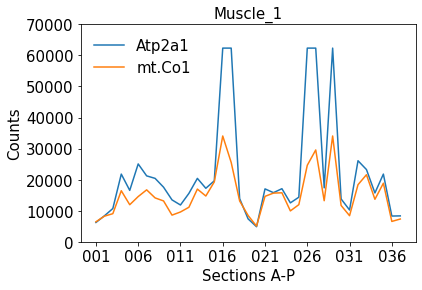

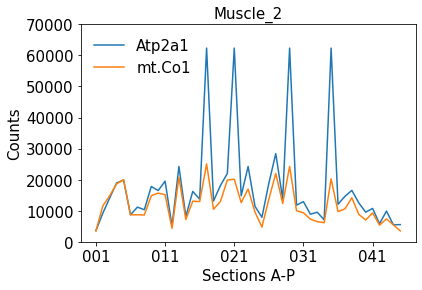

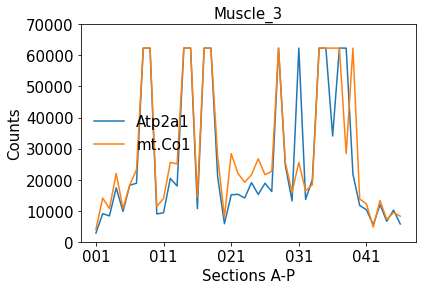

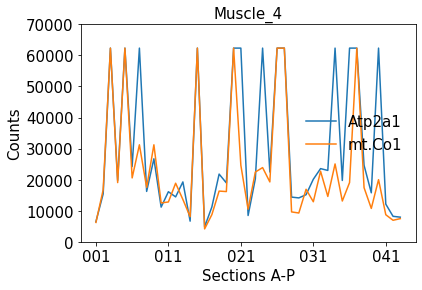

<module 'matplotlib.pyplot' from '/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [16]:
list_gene = ['ENSMUSG00000030730_Atp2a1_ProteinCoding','ENSMUSG00000064351_mt.Co1_ProteinCoding']

plotGene(data_genes_filtered, list_gene, ylabel = 'Counts' , limit=[0,70000])


In [17]:
data_genes_filtered_2={}
for key in data_genes_filtered:
    remove=[]
    for index in data_genes_filtered[key].index:
        if sum([i>60000 for i in data_genes_filtered[key].loc[index]])>=1:
            remove.append(index)
    data_genes_filtered_2[key]=data_genes_filtered[key].drop(remove, axis=0)
data_genes_filtered_2


{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             186.144646  239.860345  478.882342   
 ENSMUSG00000000056_Narf_ProteinCoding        3.000733    1.000000    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        2.000244    1.000000    3.000733   
 ENSMUSG00000000085_Scmh1_ProteinCoding       1.000000    0.000000    1.000000   
 ENSMUSG00000000088_Cox5a_ProteinCoding      58.407432   61.451282  115.602376   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding       6.003666    8.006845    6.003666   
 ENSMUSG00000116564_Riok2_ProteinCoding       2.000244    2.000244    1.000000   
 ENSMUSG00000116590_AC154200.1_lincRNA       37.163590   28.092712   35.146102   
 ENSMUSG00000117924_Tmem223_ProteinCoding     2.000244    0.000000   10.011005   
 ENS

In [18]:

#Find the position of the median value of the total transcript counts per section
data_filtered_s1_total = findNumberColumns(data_genes_filtered_2)


Number of values Muscle_1:  37
Number of values Muscle_2:  45
Number of values Muscle_3:  46
Number of values Muscle_4:  43


In [19]:
37/2

18.5

In [20]:
45/2

22.5

In [21]:
46/2

23.0

In [22]:
43/2

21.5

In [23]:
#1.Find the median: find de median value of total counts across sections by sorting the total transcript counts
#create list of medians
medians = list()


#for TM4_TAR is the position 18
medians.append(data_filtered_s1_total['Muscle_1'][18])

##for TM4_TAR is the position 24
medians.append(data_filtered_s1_total['Muscle_2'][22])

#for TM4_TAR is the position 23
medians.append(data_filtered_s1_total['Muscle_3'][23])

##for TM4_TAR is the position 24
medians.append(data_filtered_s1_total['Muscle_4'][21])


medians

[190167.96095399137, 161939.20400793833, 191586.9682475964, 147790.2635470733]

In [24]:
#normalize datasets
data_genes_filtered_normal = normalizeMedian(data_genes_filtered_2, medians)
data_genes_filtered_normal['Muscle_1']

,001,002,003,004,005,006,007,008,009,010,...,028,029,030,031,032,033,034,035,036,037
new_gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000031_H19_lincRNA,525.703164,648.449576,766.204651,822.846731,944.491446,1047.822927,1096.875150,967.340118,980.769105,876.118015,...,626.860417,688.002891,576.477369,569.623520,576.077236,471.466692,540.330983,361.448546,643.517559,434.813485
ENSMUSG00000000056_Narf_ProteinCoding,8.474564,2.703446,0.000000,0.846959,4.476638,2.076437,4.689353,5.077959,1.918515,7.227552,...,3.937809,4.237786,4.338188,0.000000,9.779795,4.795416,5.219863,4.001466,7.247198,17.201436
ENSMUSG00000000078_Klf6_ProteinCoding,5.649019,2.703446,4.801128,7.630083,7.836989,10.397431,12.520249,5.925009,10.563445,8.261069,...,11.824987,11.197021,7.232081,9.297134,8.050991,6.853109,2.609294,8.006845,16.918397,2.865155
ENSMUSG00000000085_Scmh1_ProteinCoding,2.824165,0.000000,1.599985,3.389076,4.476638,6.927380,6.253999,5.077959,3.837967,8.261069,...,3.937809,4.623605,1.445710,2.323432,2.872190,4.795416,5.219863,2.000244,2.415143,0.000000
ENSMUSG00000000088_Cox5a_ProteinCoding,164.952214,166.130244,184.962088,177.208953,152.400837,182.163596,153.577626,194.815141,173.523935,193.134628,...,150.366118,177.792090,152.276942,140.419894,120.735098,144.670885,108.040032,132.091578,150.865281,135.424333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000115987_Vps28_ProteinCoding,16.955342,21.646076,9.605776,14.426497,13.443057,19.439498,18.013305,20.356651,16.337320,10.328862,...,23.684771,17.019953,13.024113,20.931339,22.496681,21.299395,22.219726,19.041879,24.178006,17.201436
ENSMUSG00000116564_Riok2_ProteinCoding,5.649019,5.407553,1.599985,0.846959,3.357068,2.768921,3.125471,2.538049,1.918515,3.096009,...,0.000000,2.695454,2.891772,0.000000,2.872190,2.739234,2.609294,2.000244,0.000000,5.731011
ENSMUSG00000116590_AC154200.1_lincRNA,104.956104,75.947139,56.233243,77.932774,52.878773,76.437864,82.271504,64.877456,70.640060,95.991602,...,81.504244,74.446147,69.795354,39.575706,80.589402,74.915237,61.657867,57.393318,62.986167,57.436454


In [25]:
data_genes_filtered_normal

{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             525.703164  648.449576  766.204651   
 ENSMUSG00000000056_Narf_ProteinCoding        8.474564    2.703446    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        5.649019    2.703446    4.801128   
 ENSMUSG00000000085_Scmh1_ProteinCoding       2.824165    0.000000    1.599985   
 ENSMUSG00000000088_Cox5a_ProteinCoding     164.952214  166.130244  184.962088   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding      16.955342   21.646076    9.605776   
 ENSMUSG00000116564_Riok2_ProteinCoding       5.649019    5.407553    1.599985   
 ENSMUSG00000116590_AC154200.1_lincRNA      104.956104   75.947139   56.233243   
 ENSMUSG00000117924_Tmem223_ProteinCoding     5.649019    0.000000   16.017459   
 ENS

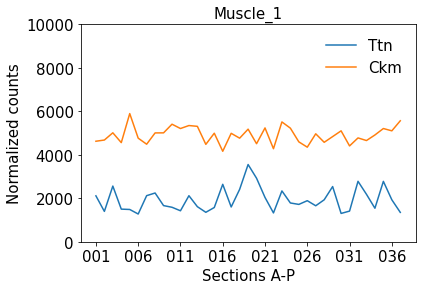

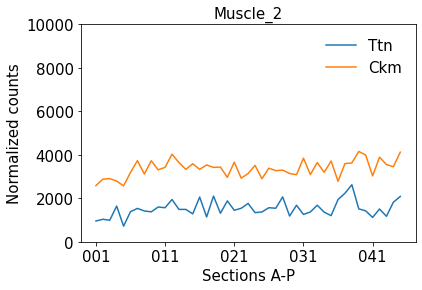

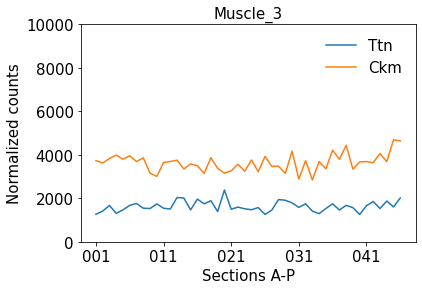

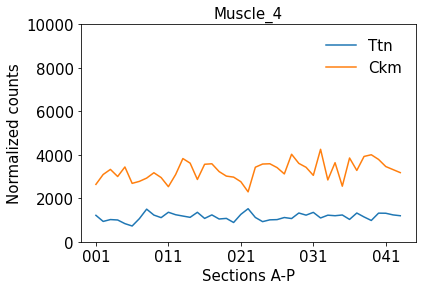

<module 'matplotlib.pyplot' from '/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [26]:
list_gene = ['ENSMUSG00000051747_Ttn_ProteinCoding', 'ENSMUSG00000030399_Ckm_ProteinCoding']

plotGene(data_genes_filtered_normal, list_gene, ylabel = 'Normalized counts' , limit=[0,10000])


In [27]:
#saved normalized 
saveCSV(data_genes_filtered_normal, label = 'genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal')

Files saved
